# Stepwise regression

A common problem encountered in regression analysis is the following:


The sweep operator is a beautiful tool for this kind of question, because **including/excluding a variable does not require re-fitting the entire model**. Instead, just *sweep* the variable in if you want to include its effect, and if it isn't good, *sweep* it out!

In [1]:
import sweepystats as sw
import numpy as np

Lets simulate some data. I simulated $p=5$ covariates from

$$\mathbf{y} = \mathbf{X}\boldsymbol{\beta} + N(0, \mathbf{I})$$

but only $k=3$ randomly chosen variables influence the response. 

In [2]:
n, p, k = 20, 5, 3 # number of samples, covariates, causal covariates
np.random.seed(123) # for reproducibility
X = np.random.normal(n, p, size=(n, p))
beta = np.zeros(p)
beta[np.random.choice(np.arange(p), size=k, replace=False)] = np.random.randn(k)
y = X @ beta + np.random.normal()

Form an instance of `LinearRegression` class:

In [3]:
ols = sw.LinearRegression(X, y)

### Including/excluding covariates corresponds to sweeping the variable in/out

For example, lets "sweep in" the first variable.

In [4]:
ols.include_k(0) # include the first variable in regression

After sweeping in the first variable, we can examine the fitted $\hat{\beta}$:

In [5]:
ols.coef()

array([-0.59749513])

$\hat{\beta}$ has length 1 because only 1 variable is included in the model. If we include another variable:

In [6]:
ols.include_k(1) # include another variable in regression
ols.coef()

array([-1.08801076,  0.55909226])

$\hat{\beta}$ now has length 2!

We can examine the sum-of-squares residual at any point

In [7]:
ols.resid()

np.float64(923.9790070962508)

Obviously, including more variables will decrease the sum of squares residual $\|\mathbf{y} - \hat{\mathbf{y}}\|^2$

In [8]:
ols = sw.LinearRegression(X, y)
resids = []
for i in range(p):
    ols.include_k(i) # sweep the ith variable in (include it in regression)
    resids.append(ols.resid()) # save sum-of-square residual

We can visualize the residuals

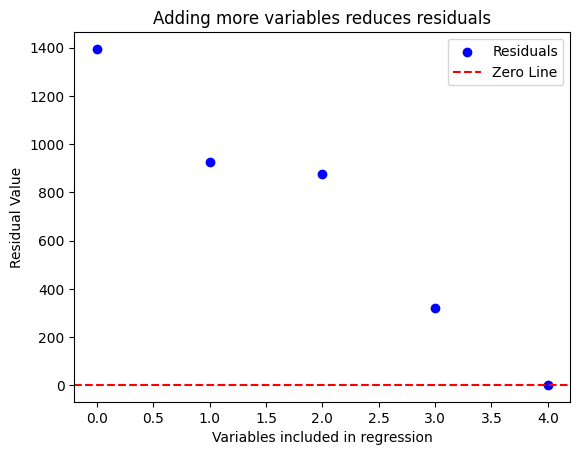

In [9]:
import matplotlib.pyplot as plt
plt.scatter(range(p), resids, color='blue', label='Residuals')
plt.axhline(0, color='red', linestyle='--', label='Zero Line')
plt.xlabel('Variables included in regression')
plt.ylabel('Residual Value')
plt.title('Adding more variables reduces residuals')
plt.legend()
plt.show()

So it seems adding the 2nd, 4th, and 5th variable improved model fit significantly (by reducing sum-of-squared residual to virtually 0). How do we statistically determine whether they are redundant? We can test the hypothesis $H_k = 0$ using an F-test:

In [10]:
# test whether kth variable is significant
for k in range(p):
    f_stat, pval = ols.f_test(k)
    print(f"Variable {k} has p-value {pval}")

Variable 0 has p-value 9.062122146792274e-24
Variable 1 has p-value 0.4648260563197989
Variable 2 has p-value 0.19236569475852966
Variable 3 has p-value 1.5600761098077415e-16
Variable 4 has p-value 7.343646064572416e-18


So the 1st, 4th, and 5th variable is significant. We can compare this against the true beta coefficient:

In [11]:
beta # true beta

array([-1.97788793,  0.        ,  0.        ,  0.64205469,  0.71226464])

We can also check the OLS beta:

In [12]:
ols.coef() # estimated beta

array([-1.92696789,  0.00979312,  0.01957962,  0.65187879,  0.74881869])

**Conclusion**:

+ Stepwise regression using F-test worked in identifying the correct model (in this case)
+ Adding/removing variables from the model corresponds to sweeping the variable in/out. This is an rank-1 update operation, requiring $\mathcal{O}(p^2)$ flops, and does NOT require re-fitting parameters of the model
+ Visually examining the improvement in residual error will result in a misleading model!